This notebook presents how to fit log Gaussian tuning curves to the data from the NSDsyn dataset. In this example, the data is first binned by eccentricity (0.5-1, 1-2, & 2-4 deg) and then averaged across stimulus classes. The tuning curves are fitted for each eccentricity bin. 

Related snakemake rules: `binning`, `fit_tuning_curves`

# Configurations

In [1]:
import sys
sys.path.append('..')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sfp_nsdsyn import *
import warnings
import itertools

warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

In [2]:
output_dir='/Volumes/server/Projects/sfp_nsd/derivatives'
fig_dir=os.path.join(output_dir, 'figures/sfp_model/results_1D/nsdsyn')
precision_dir='/Volumes/server/Projects/sfp_nsd/derivatives/dataframes/nsdsyn/precision'

In [8]:
stim_classes=['annulus', 'pinwheel', 'forward spiral', 'reverse spiral']
roi_list=['V1','V2','V3']
e1, e2=0.5, 4
enum=7 #'log3'
lr = 0.005
max_epoch = 8000
subj_list = [utils.sub_number_to_string(sn, 'nsdsyn') for sn in np.arange(1,9)]
subj='subj01'
roi='V1'
voxels='pRFcenter'

# Load betas and experimental design information

In [4]:
subj_df = pd.read_csv(os.path.join(output_dir, 'dataframes', 'nsdsyn', 'model', f'dset-nsdsyn_sub-{subj}_roi-{roi}_vs-{voxels}.csv'))
subj_df = subj_df.query('~names.str.contains("intermediate").values')


# 1. Binning

In [5]:
bin_list, bin_labels = tuning.get_bin_labels(e1, e2, 'log3')
subj_df['ecc_bin'] = tuning.bin_ecc(subj_df['eccentricity'], bin_list, bin_labels)
#bin_df = subj_df.groupby(['sub','vroinames','ecc_bin','freq_lvl','names']).mean().reset_index()
bin_df = tuning.summary_stat_for_ecc_bin(subj_df,
                                       to_group=['sub','vroinames','ecc_bin','freq_lvl','names'],
                                       to_bin=['betas', 'local_sf'],
                                       central_tendency='mean')

## Sanity check: Datapoints only

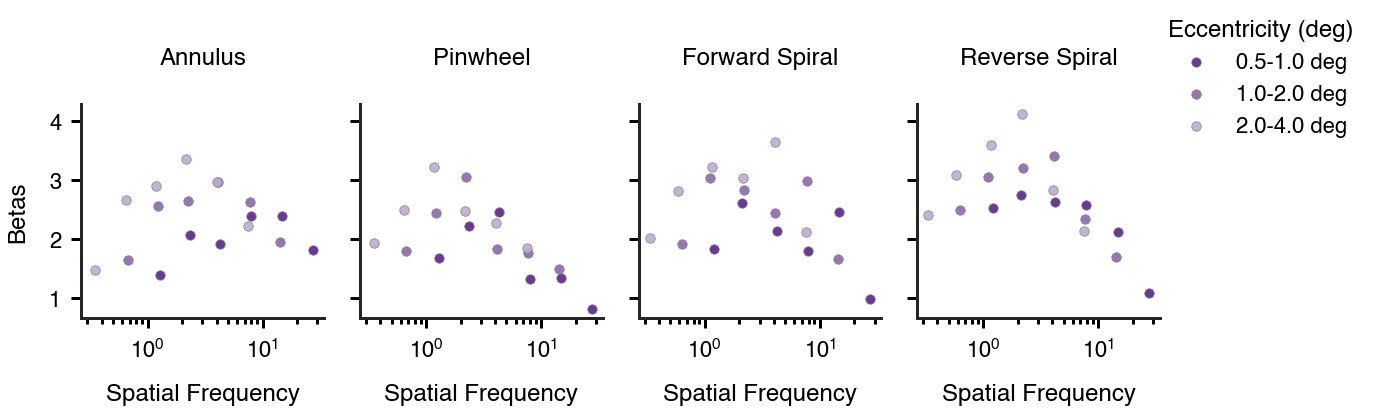

In [7]:
ecc_colors = utils.get_continuous_colors(len(bin_labels)+1, '#3f0377')
ecc_colors = ecc_colors[1:][::-1]
vis1D.plot_datapoints(bin_df, 'local_sf', 'betas', hue='ecc_bin', hue_order=bin_labels, 
                      col='names', col_order=stim_classes, 
                    height=6, aspect=0.7, lgd_title='Eccentricity (deg)',
                    palette=ecc_colors)

# 2. Fitting log Gaussian curves for every eccentricity bin

In [8]:
avg_bin_df = bin_df.groupby(['sub','ecc_bin','vroinames','freq_lvl']).mean().reset_index()


In [9]:
loss_history, model_history = pd.DataFrame({}), pd.DataFrame({})
for ecc_bin in avg_bin_df.ecc_bin.unique():
    print(f'{ecc_bin}')
    tmp = avg_bin_df.query('ecc_bin == @ecc_bin')
    my_model = tuning.LogGaussianTuningModel()
    my_dataset = tuning.LogGaussianTuningDataset(tmp['local_sf'], tmp['betas'])
    tmp_loss_history, tmp_model_history = tuning.fit_tuning_curves(my_model, my_dataset, 
                                                                   max_epoch=100, print_every=50, 
                                                                   learning_rate=0.01)
    tmp_model_history['ecc_bin'] = ecc_bin
    tmp_loss_history['ecc_bin'] = ecc_bin
    model_history = pd.concat((model_history, tmp_model_history), axis=0)
    loss_history = pd.concat((loss_history, tmp_loss_history), axis=0)


0.5-1.0 deg
**epoch no.0 loss: 3.88222
**epoch no.49 loss: 2.59849
**epoch no.99 loss: 1.15669
**epoch no.100: Finished! final params {'slope': 2.076, 'mode': 1.692, 'sigma': 1.587}
Elapsed time: 0.07 sec 

1.0-2.0 deg
**epoch no.0 loss: 5.89247
**epoch no.49 loss: 4.49853
**epoch no.99 loss: 2.53081
**epoch no.100: Finished! final params {'slope': 1.18, 'mode': 2.434, 'sigma': 1.775}
Elapsed time: 0.05 sec 

2.0-4.0 deg
**epoch no.0 loss: 6.61654
**epoch no.49 loss: 4.48473
**epoch no.99 loss: 2.4692
**epoch no.100: Finished! final params {'slope': 1.529, 'mode': 1.371, 'sigma': 1.991}
Elapsed time: 0.05 sec 


# 3. Plotting the results

## 3.1. loss and model history checks 

In [103]:
args = ['class', 'lr', 'eph', 'dset', 'sub', 'roi', 'curbin']
l, m = [], []
for curbin, subj in itertools.product([0,1,2], subj_list):
    loss_file_name = f'loss-history_class-avg_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-{enum}_curbin-{curbin}_dset-nsdsyn_sub-{subj}_roi-{roi}_vs-{voxels}.h5'
    model_file_name =f'model-history_class-avg_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-{enum}_curbin-{curbin}_dset-nsdsyn_sub-{subj}_roi-{roi}_vs-{voxels}.h5'
    l.append(os.path.join(output_dir, 'sfp_model', 'results_1D', 'nsdsyn', loss_file_name))
    m.append(os.path.join(output_dir, 'sfp_model', 'results_1D', 'nsdsyn', model_file_name))


In [104]:
loss_df = utils.load_dataframes(l, *args)
model_df = utils.load_dataframes(m, *args)

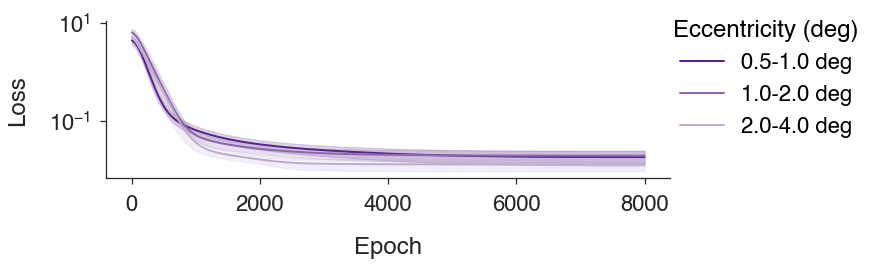

In [153]:
vis.plot_loss_history(loss_df[loss_df['epoch'] % 3 != 0], 
                      hue='ecc_bin', hue_order=bin_labels, 
                      lgd_title='Eccentricity (deg)', 
                      log_y=True, palette=ecc_colors, errorbar='se')

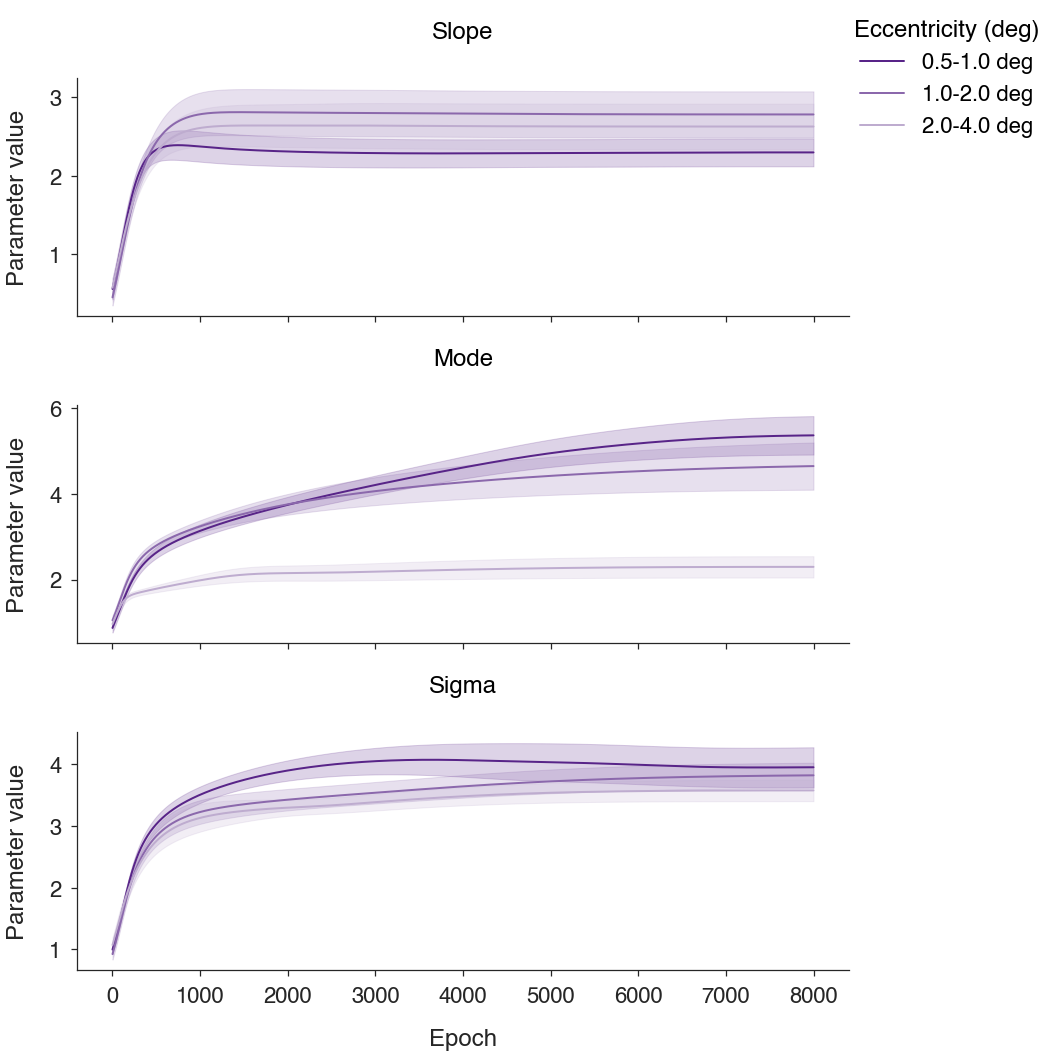

In [154]:
vis.plot_param_history(model_df[loss_df['epoch'] % 3 != 0], params=['slope','mode','sigma'],
                       hue='ecc_bin', hue_order=bin_labels, 
                       lgd_title='Eccentricity (deg)', errorbar='se',
                       palette=ecc_colors)

## 3.2 Tuning curves

### Load the data and the model

In [520]:

f, m = [], []
for subj, roi in itertools.product(subj_list, roi_list):
    file_name = f'e1-{e1}_e2-{e2}_nbin-log3_dset-nsdsyn_sub-{subj}_roi-{roi}_vs-{voxels}.csv'
    f.append(os.path.join(output_dir, 'dataframes', 'nsdsyn', 'binned', file_name))

subj_df = utils.load_dataframes(f)
subj_df = subj_df.groupby(['sub','ecc_bin','vroinames','freq_lvl']).mean().reset_index()

In [521]:
args = ['sub', 'class','dset', 'lr', 'eph', 'roi', 'e1', 'e2', 'nbin', 'curbin']

pt_file_list = []
for subj, roi, curbin in itertools.product(subj_list, roi_list, [0,1,2]):
    file_name = f'model-params_class-avg_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-log3_curbin-{curbin}_dset-nsdsyn_sub-{subj}_roi-{roi}_vs-{voxels}.pt'
    pt_file_list.append(os.path.join(output_dir, 'sfp_model', 'results_1D', 'nsdsyn', file_name))
    
tuning_df = tuning.load_all_models(pt_file_list, *args)

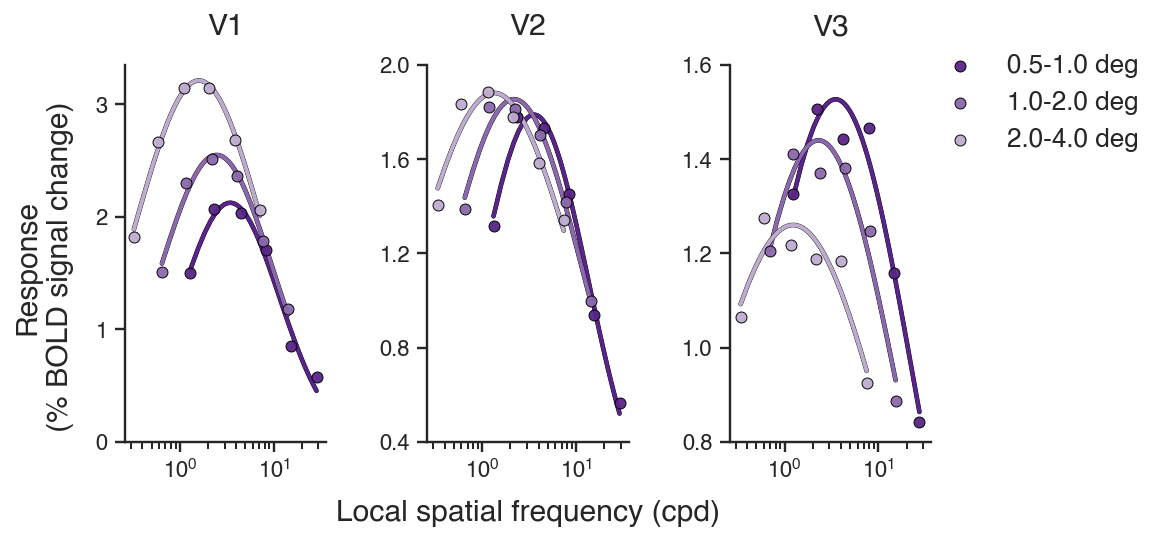

In [522]:
tmp_subj_df = subj_df.query('sub == "subj06"')
tmp_tuning_df = tuning_df.query('sub == "subj06"')
fig_name = os.path.join(output_dir,"figures", "sfp_model","results_1D", "nsdsyn", f'tuning_class_avg_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-log3_curbin-all_dset-nsdsyn_sub-subj06_roi-all_vs-pRFsize.pdf')
vis1D.plot_sf_curves(df=tmp_subj_df, x='local_sf', y='betas', hue='ecc_bin',
                     col='vroinames', params_df=tmp_tuning_df, lgd_title=None,
                     save_path=fig_name)

In [523]:
f, m = [], []
for subj, roi in itertools.product(subj_list, roi_list):
    file_name = f'baseline_sub-{subj}_roi-{roi}_vs-{voxels}.csv'
    f.append(os.path.join(output_dir, 'dataframes', 'nsdsyn', 'baseline', file_name))

baseline_df = utils.load_dataframes(f)
bin_list, bin_labels = tuning.get_bin_labels(e1, e2, '7')
baseline_df['ecc_bin'] = tuning.bin_ecc(baseline_df['eccentricity'], bin_list, bin_labels)
baseline_df = baseline_df.groupby(['sub','ecc_bin','vroinames']).mean().reset_index()
baseline_df

,sub,ecc_bin,vroinames,voxel,stim_idx,betas,eccentricity,angle,size,visualrois,eccrois
0,subj01,0.5-1.0 deg,V1,2402.078838,1.5,2.088643,0.771223,3.699362,34.175164,1.658368,1.943292
1,subj01,0.5-1.0 deg,V2,3032.368595,1.5,1.957244,0.775891,3.487756,22.585099,3.548760,1.700826
2,subj01,0.5-1.0 deg,V3,2709.570218,1.5,1.678264,0.734101,3.028439,4.246631,5.434625,1.665860
3,subj01,1.0-1.5 deg,V1,3042.908623,1.5,2.317843,1.242285,2.942247,15.210866,1.526384,2.691120
4,subj01,1.0-1.5 deg,V2,3517.490385,1.5,1.953770,1.255826,2.893588,11.281535,3.284856,2.728365
...,...,...,...,...,...,...,...,...,...,...,...
163,subj08,3.0-3.5 deg,V2,2514.873096,1.5,2.834998,3.207351,2.936779,5.594691,3.370558,3.928934
164,subj08,3.0-3.5 deg,V3,2263.122807,1.5,2.802834,3.243405,3.028089,2.127086,5.391813,4.286550
165,subj08,3.5-4.0 deg,V1,2223.464646,1.5,2.471046,3.768197,4.091477,2.743226,1.656566,4.388889
166,subj08,3.5-4.0 deg,V2,2793.050420,1.5,2.430189,3.758644,3.194935,1.615041,3.336134,4.058824


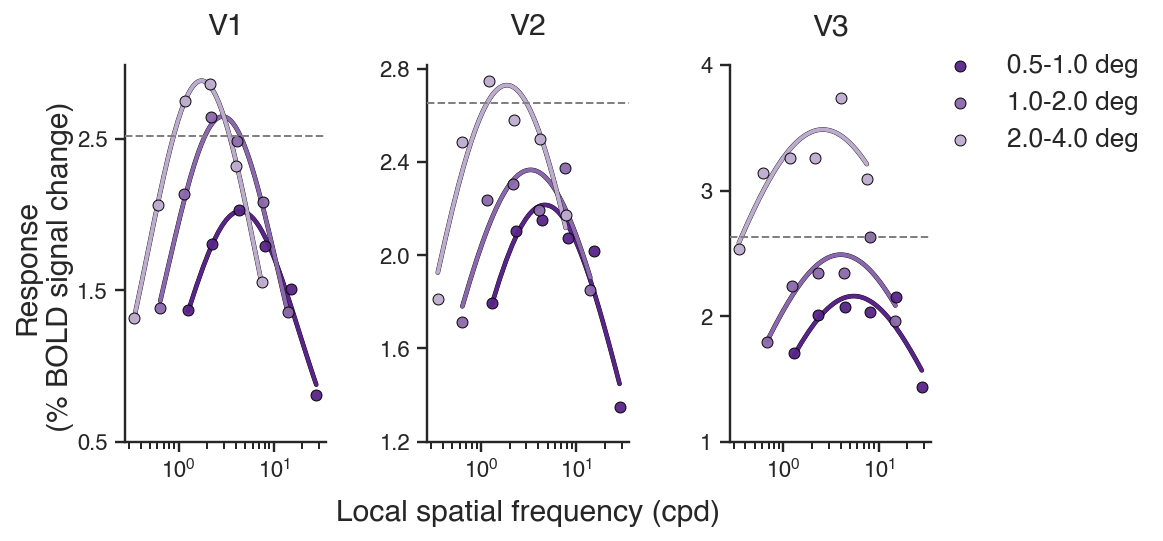

In [554]:
example_subj='subj04'
tmp_subj_df = subj_df.query('sub == @example_subj')
tmp_tuning_df = tuning_df.query('sub == @example_subj')
baseline_example_df  = baseline_df.query('sub == @example_subj')
fig_name = os.path.join(fig_dir, f'{example_subj}_example_baseline.pdf')

fig, axes = vis1D.plot_sf_curves(df=tmp_subj_df, x='local_sf', y='betas', hue='ecc_bin',baseline=baseline_example_df,
                         col='vroinames', params_df=tmp_tuning_df, lgd_title=None,
                         save_path=fig_name)

    

In [545]:
baseline_example_df

,sub,ecc_bin,vroinames,voxel,stim_idx,betas,eccentricity,angle,size,visualrois,eccrois
105,subj06,0.5-1.0 deg,V1,2574.690031,1.5,1.752835,0.736105,3.584336,29.798853,1.542056,1.895639
106,subj06,0.5-1.0 deg,V2,3021.336111,1.5,1.609658,0.731331,3.474116,13.460124,3.505556,1.845833
107,subj06,0.5-1.0 deg,V3,2863.150442,1.5,1.246158,0.777551,3.310216,15.543747,5.545354,1.929204
108,subj06,1.0-1.5 deg,V1,3036.152318,1.5,1.818201,1.244922,3.616348,13.821817,1.481236,2.735099
109,subj06,1.0-1.5 deg,V2,2955.869930,1.5,1.647140,1.251849,3.059805,9.062056,3.476923,2.746853
110,subj06,1.0-1.5 deg,V3,2482.233732,1.5,1.173301,1.214753,3.721811,14.247985,5.602922,2.743692
111,subj06,1.5-2.0 deg,V1,3480.978873,1.5,1.574689,1.768344,3.727249,14.905662,1.572770,3.065728
112,subj06,1.5-2.0 deg,V2,3367.295238,1.5,1.463281,1.738828,3.110704,8.167250,3.495238,3.069841
113,subj06,1.5-2.0 deg,V3,2363.978972,1.5,1.022917,1.719458,3.680112,12.921639,5.614486,3.156542
114,subj06,2.0-2.5 deg,V1,3209.487654,1.5,1.416110,2.236244,3.520453,12.474919,1.570988,3.567901


## 3.3 Preferred period as function of eccentricity

We plot preferred period as a function of eccentricity averaged across subjects. 
To calculate the average, we use precision as weights for each subject. 

### Load precision for each subject

In [672]:
file_list = []
for subj, roi in itertools.product(subj_list, ['V1','V2','V3']):
    f = os.path.join(output_dir, 'dataframes', 'nsdsyn', 'precision', 
                     f'precision-v_dset-nsdsyn_sub-{subj}_roi-{roi}_vs-pRFsize.csv')
    file_list.append(f)
    
precision_v = utils.load_dataframes(file_list)
precision_s = precision_v.groupby(['sub','vroinames']).mean().reset_index()
precision_s['precision'] = 1 / precision_s['sigma_v_squared']

In [673]:
args = ['sub', 'class','dset', 'lr', 'eph', 'roi', 'e1', 'e2', 'nbin', 'curbin']
enum='log3'
pt_file_list = []
for subj, roi, curbin in itertools.product(subj_list, roi_list, np.arange(0, 3)):
    file_name = f'model-params_class-avg_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-{enum}_curbin-{curbin}_dset-nsdsyn_sub-{subj}_roi-{roi}_vs-{voxels}.pt'
    pt_file_list.append(os.path.join(output_dir, 'sfp_model', 'results_1D', 'nsdsyn', file_name))
    
tuning_df = tuning.load_all_models(pt_file_list, *args)

In [674]:
tuning_with_precision_df = tuning_df.merge(precision_s[['sub','vroinames','precision']], on=['sub', 'vroinames'])

fit_df = vis1D.fit_line_to_weighted_mean(tuning_with_precision_df, 'mode', 'precision', groupby=['vroinames'])

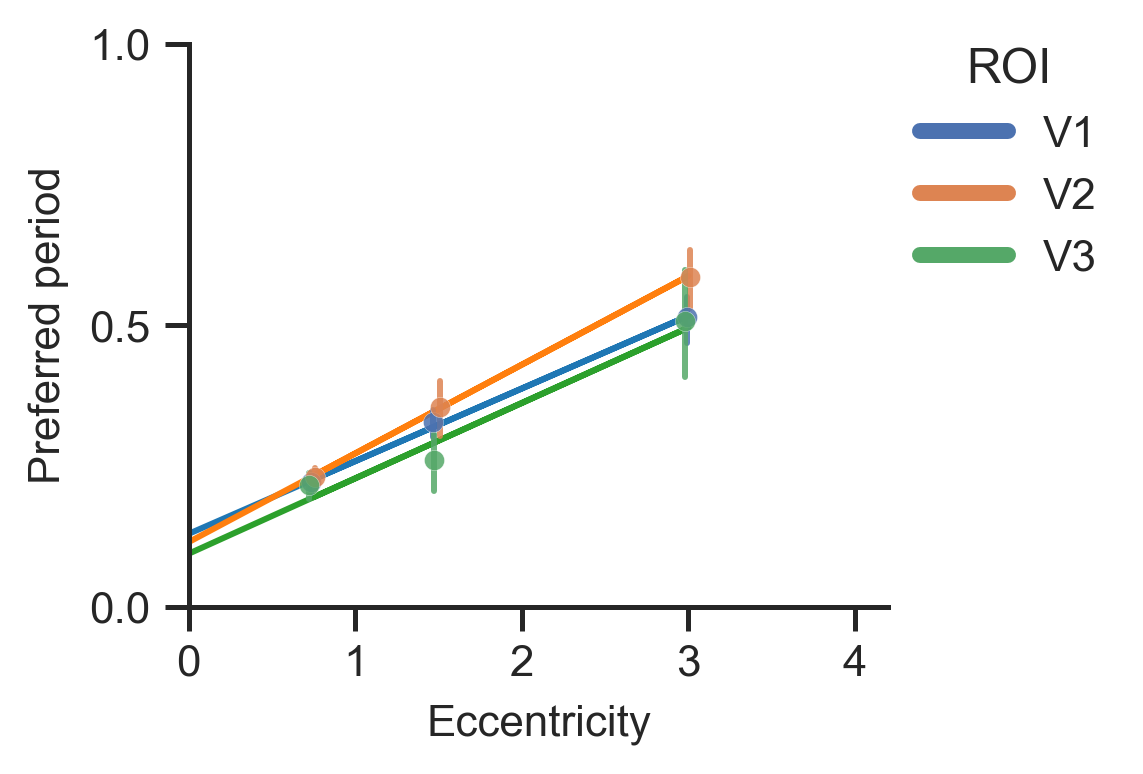

In [677]:
g = vis1D.plot_preferred_period(tuning_with_precision_df, 
                                sf_peak='mode', precision='precision', hue='vroinames', 
                                hue_order=['V1','V2','V3'], fit_df=fit_df, lgd_title='ROI',
                                save_path=os.path.join(fig_dir, f'preferred_period_avg_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-log3_dset-nsdsyn_vs-{voxels}.pdf'))


# Each stimulus class's preferred period as a function of eccentricity

In [430]:
args = ['sub', 'class','dset', 'lr', 'eph', 'roi', 'e1', 'e2', 'nbin', 'curbin']

pt_file_list = []
for subj, roi, curbin in itertools.product(subj_list, roi_list, np.arange(0, 3)):
    for stim_class in stim_classes:
        stim_class = stim_class.replace(' ', '-')
        file_name = f'model-params_class-{stim_class}_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-{enum}_curbin-{curbin}_dset-nsdsyn_sub-{subj}_roi-{roi}_vs-{voxels}.pt'
        pt_file_list.append(os.path.join(output_dir, 'sfp_model', 'results_1D', 'nsdsyn', file_name))
    
tuning_df = tuning.load_all_models(pt_file_list, *args)

In [431]:
tuning_with_precision_df = tuning_df.merge(precision_s[['sub','vroinames','precision']], on=['sub', 'vroinames'])
fit_df = vis1D.fit_line_to_weighted_mean(tuning_with_precision_df, 'mode', 'precision', groupby=['vroinames','names'])

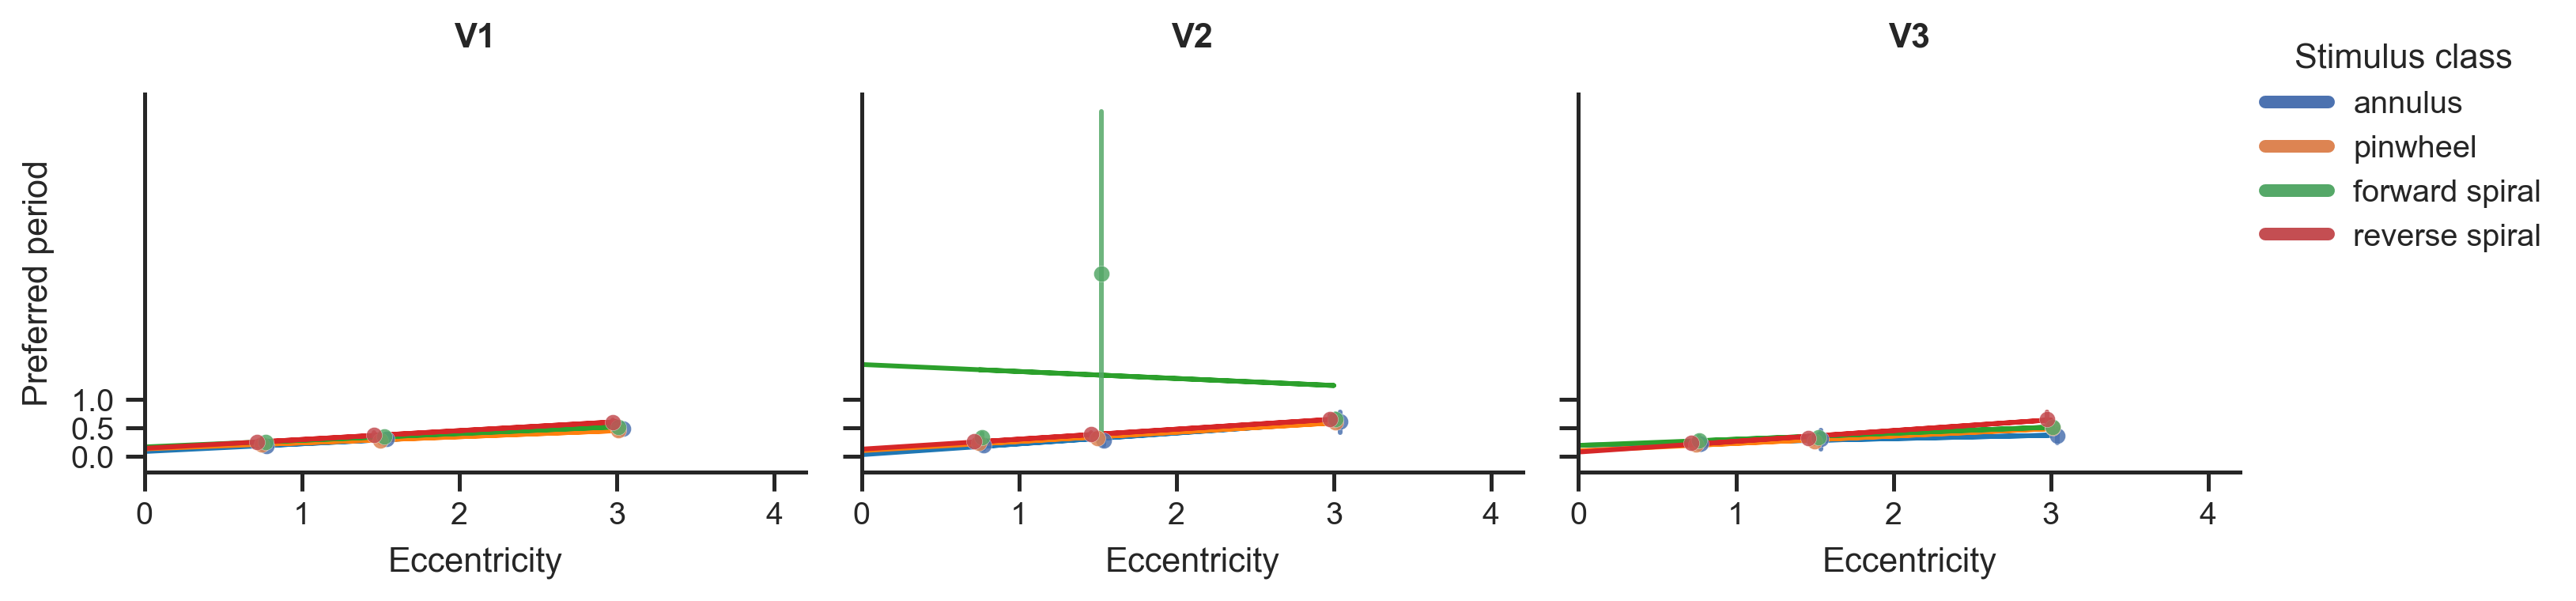

In [432]:
g = vis1D.plot_preferred_period(tuning_with_precision_df, col='vroinames', col_order=roi_list,
                                sf_peak='mode', precision='precision', hue='names', width=7,
                                hue_order=stim_classes, fit_df=fit_df, lgd_title='Stimulus class')

,slope,mode,sigma,sub,names,dset,lr_rate,max_epoch,vroinames,e1,e2,nbin,curbin,ecc_bin,precision,ecc,pp
18,2.253163,4.858312,5.665891,subj01,forward spiral,nsdsyn,0.005,8000,V2,0.5,4,log3,1,1.0-2.0 deg,1.548457,1.5,0.205833
54,2.173597,0.039047,8.928065,subj02,forward spiral,nsdsyn,0.005,8000,V2,0.5,4,log3,1,1.0-2.0 deg,0.881836,1.5,25.609896
90,2.940261,6.501976,4.422491,subj03,forward spiral,nsdsyn,0.005,8000,V2,0.5,4,log3,1,1.0-2.0 deg,0.748543,1.5,0.153799
126,2.078771,5.209052,6.341847,subj04,forward spiral,nsdsyn,0.005,8000,V2,0.5,4,log3,1,1.0-2.0 deg,0.872796,1.5,0.191974
162,3.303940,2.230087,3.844835,subj05,forward spiral,nsdsyn,0.005,8000,V2,0.5,4,log3,1,1.0-2.0 deg,0.737055,1.5,0.448413
198,1.595648,2.169053,2.837367,subj06,forward spiral,nsdsyn,0.005,8000,V2,0.5,4,log3,1,1.0-2.0 deg,1.866259,1.5,0.461031
234,4.036446,2.548296,3.419777,subj07,forward spiral,nsdsyn,0.005,8000,V2,0.5,4,log3,1,1.0-2.0 deg,0.585363,1.5,0.392419
270,3.146333,0.849075,5.066793,subj08,forward spiral,nsdsyn,0.005,8000,V2,0.5,4,log3,1,1.0-2.0 deg,0.637120,1.5,1.177752


<AxesSubplot:xlabel='precision', ylabel='pp'>

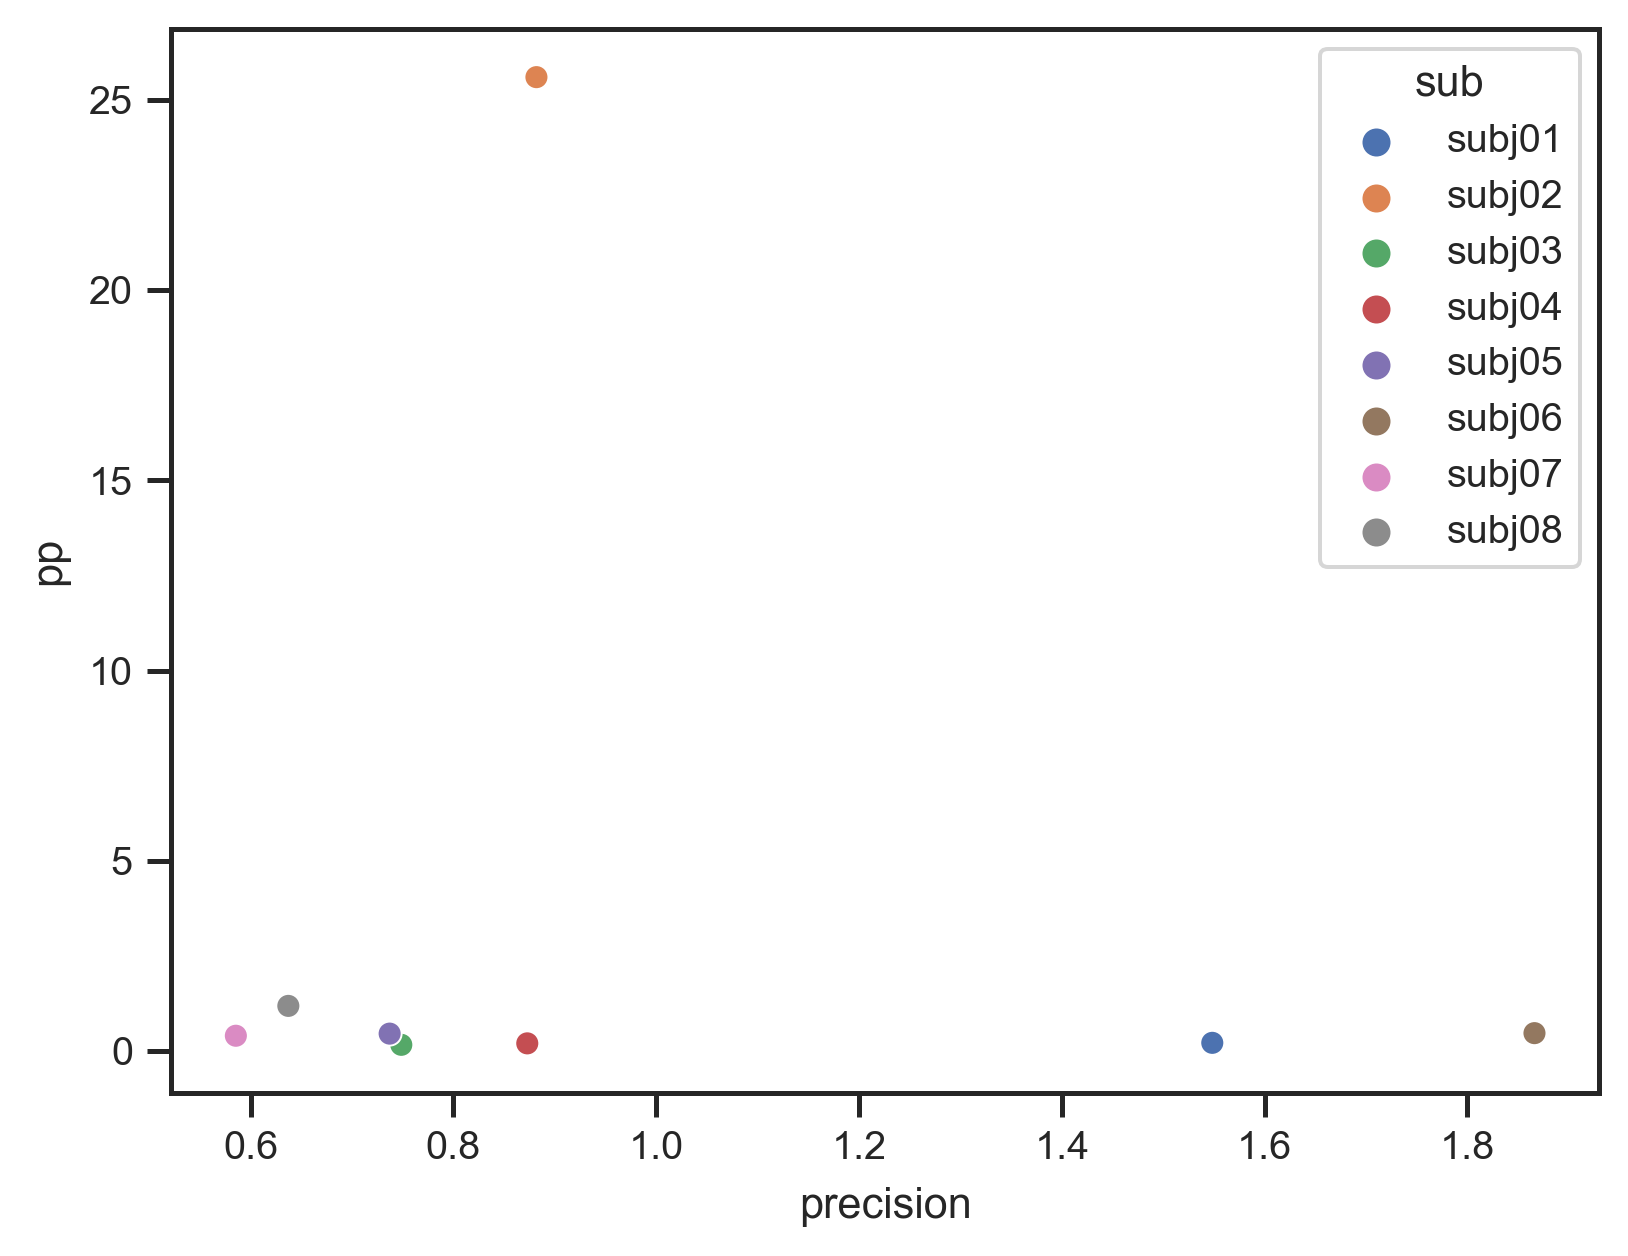

In [439]:
test = tuning_with_precision_df.query('vroinames == "V2" & names == "forward spiral" & curbin == "1"')
sns.scatterplot(data=test, x='precision', y='pp', hue='sub')

# Baseline? 

In [568]:
example_subj = 'subj04'
tmp_df = subj_df.query('sub == @example_subj & vroinames == "V1" & ecc_bin == @bin_labels[0]')
params_tmp_df = tuning_df.query('sub == @example_subj & vroinames == "V1" & ecc_bin == @bin_labels[0]')

,slope,mode,sigma,sub,names,dset,lr_rate,max_epoch,vroinames,e1,e2,nbin,curbin,ecc_bin
0,2.373721,3.950246,2.557054,subj01,avg,nsdsyn,0.005,8000,V1,0.5,4,log3,0,0.5-1.0 deg
0,2.937244,2.571746,2.372591,subj01,avg,nsdsyn,0.005,8000,V1,0.5,4,log3,1,1.0-2.0 deg
0,3.347748,1.686050,2.253984,subj01,avg,nsdsyn,0.005,8000,V1,0.5,4,log3,2,2.0-4.0 deg
0,2.078254,4.495413,3.870455,subj01,avg,nsdsyn,0.005,8000,V2,0.5,4,log3,0,0.5-1.0 deg
0,2.232673,3.660676,4.095217,subj01,avg,nsdsyn,0.005,8000,V2,0.5,4,log3,1,1.0-2.0 deg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2.921265,3.275620,3.640059,subj08,avg,nsdsyn,0.005,8000,V2,0.5,4,log3,1,1.0-2.0 deg
0,2.994702,1.855636,3.149396,subj08,avg,nsdsyn,0.005,8000,V2,0.5,4,log3,2,2.0-4.0 deg
0,1.878122,6.792418,3.676619,subj08,avg,nsdsyn,0.005,8000,V3,0.5,4,log3,0,0.5-1.0 deg
0,2.701339,6.135540,3.864834,subj08,avg,nsdsyn,0.005,8000,V3,0.5,4,log3,1,1.0-2.0 deg


In [662]:
bin_list, bin_labels = tuning.get_bin_labels(e1, e2, 'log3')

bandwidth_df = pd.DataFrame({})

for example_subj, b, roi in itertools.product(subj_list, bin_labels, roi_list):
    tmp_subj_df = subj_df.query('sub == @example_subj & vroinames == @roi & ecc_bin == @b')
    params_tmp_df = tuning_df.query('sub == @example_subj & vroinames == @roi & ecc_bin == @b')
    bandwidth = tuning.get_bandwidth_in_octave(tmp_subj_df, 'local_sf', params_tmp_df)
    tmp_df = pd.DataFrame({})    
    tmp_df['sub'] = [example_subj]
    tmp_df['vroinames'] = [roi]
    tmp_df['ecc_bin'] = [b]
    tmp_df['bandwidth'] = [bandwidth]
    bandwidth_df = pd.concat((bandwidth_df, tmp_df), axis=0)

In [663]:
bandwidth_df = bandwidth_df.merge(precision_s[['sub','vroinames','precision']], on=['sub', 'vroinames'])

In [688]:
fit_df = vis1D.fit_line_to_weighted_mean(bandwidth_df, 'bandwidth', 'precision', groupby=['vroinames'])

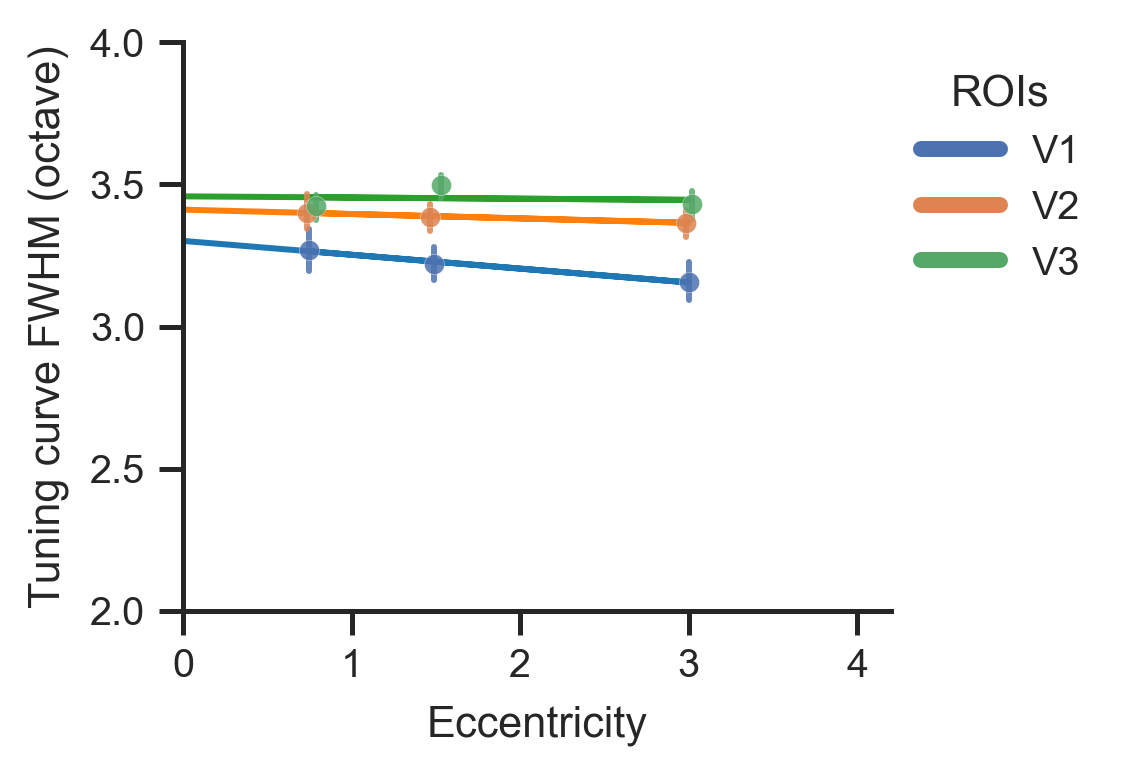

In [690]:
vis1D.plot_bandwidth_in_octave(bandwidth_df, 'bandwidth', 'precision', 'vroinames', roi_list, fit_df=fit_df,
                              pal=sns.color_palette("tab10"),
                              lgd_title='ROIs',
                              col=None, col_order=None,
                              suptitle=None, width=3.25, errorbar=("ci", 68),
                              save_path=None)

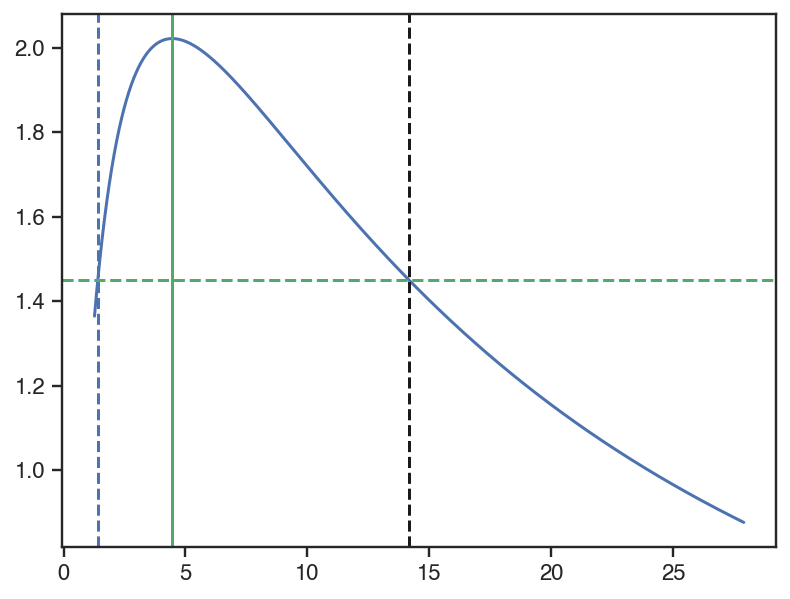

In [647]:
plt.plot(pred_x, pred_y)
plt.axvline(params_tmp_df['mode'].values[0], color='g')
plt.axhline(results_half_y, linestyle='--', color='g')
plt.axvline(results_half_x_min, linestyle='--', color='b')
plt.axvline(results_half_x_max, linestyle='--', color='k')
